In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

In [2]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """
    # Place your Module 2 solution here
        # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens / num_tokens
    num_characters = len("".join(tokens))
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
      # print the five most common tokens
        print("The five most common tokens are: ", Counter(tokens).most_common(5))
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])


    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    tokens = [token for token in tokens if not token.lower() in sw]
    return(tokens)
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))


RE_TOKEN = re.compile(r"""
               ( [#]?[@\w'’\.\-\:]*\w     # words, hash tags and email adresses
               | [:;<]\-?[\)\(3]          # coarse pattern for basic text emojis
               | [\U0001F100-\U0001FFFF]  # coarse code range for unicode emojis
               )
               """, re.VERBOSE)

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    return RE_TOKEN.findall(text)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

In [16]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-509/Module 1/assignment_1/ADS-509_earnest/"
lyrics_folder = "lyrics/"

In [17]:
# read in the lyrics here
artist_folders = os.listdir(data_location + lyrics_folder)

artist_lyrics_d = dict()

for artist in artist_folders :
    
    artist_lyrics_d[artist] = dict()
    
    artist_files = os.listdir(data_location + lyrics_folder + artist)
    
    for f_name in artist_files:
        
        # I stored the lyrics data in a dictionary with 
        # two dimensions of keys: artist and song. 
        # The value was the file contents. 
        with open(data_location + lyrics_folder + artist + "/" + f_name) as infile : 
            
            file_contents = infile.read()
            artist_lyrics_d[artist][f_name] = file_contents

In [18]:
#create dataframe with filename, lyrics and artist for cher
filename_list = []
song_text_list = []

for k,v in artist_lyrics_d["taylor"].items():
    filename_list.append(k)
    song_text_list.append(v)

data = {'filename': filename_list, 'lyrics': song_text_list}
lyrics_data = pd.DataFrame.from_dict(data)
lyrics_data['artist'] = "taylor"

In [19]:
lyrics_data.head()

,filename,lyrics,artist
0,httpswww_azlyrics_com_taylorswift_22.txt,22\n\nIt feels like a perfect night to dress u...,taylor
1,httpswww_azlyrics_com_taylorswift_22taylorsver...,22 (Taylor's Version)\n\nIt feels like a perfe...,taylor
2,httpswww_azlyrics_com_taylorswift_afterglow.txt,"Afterglow\n\nI blew things out of proportion, ...",taylor
3,httpswww_azlyrics_com_taylorswift_aintnothingb...,"Ain't Nothing 'Bout You\n\nThe way you look, t...",taylor
4,httpswww_azlyrics_com_taylorswift_allbecauseof...,All Because Of Ellen\n\nAll the other kids wit...,taylor


In [20]:
#Remove song titles

#creates song title column, takes the song title from the lyric column
lyrics_data["song_title"] = lyrics_data["lyrics"].str.split("\n\n", expand=True)[0]

#deletes the song title from the lyrics column
lyrics_data["lyrics"] = lyrics_data["lyrics"].str.split("\n\n", expand=True)[1]

#removes the \n from the lyrics, replaces with ,
lyrics_data["lyrics"] = lyrics_data["lyrics"].str.replace("\n"," ")

In [21]:
lyrics_data.head()

,filename,lyrics,artist,song_title
0,httpswww_azlyrics_com_taylorswift_22.txt,It feels like a perfect night to dress up like...,taylor,22
1,httpswww_azlyrics_com_taylorswift_22taylorsver...,It feels like a perfect night To dress up like...,taylor,22 (Taylor's Version)
2,httpswww_azlyrics_com_taylorswift_afterglow.txt,"I blew things out of proportion, now you're bl...",taylor,Afterglow
3,httpswww_azlyrics_com_taylorswift_aintnothingb...,"The way you look, the way you laugh, The way y...",taylor,Ain't Nothing 'Bout You
4,httpswww_azlyrics_com_taylorswift_allbecauseof...,All the other kids with the pumped up kicks Yo...,taylor,All Because Of Ellen


In [22]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

In [23]:
lyrics_data.head()

,filename,lyrics,artist,song_title,tokens,num_tokens
0,httpswww_azlyrics_com_taylorswift_22.txt,It feels like a perfect night to dress up like...,taylor,22,"[feels, like, perfect, night, dress, like, hip...",238
1,httpswww_azlyrics_com_taylorswift_22taylorsver...,It feels like a perfect night To dress up like...,taylor,22 (Taylor's Version),"[feels, like, perfect, night, dress, like, hip...",212
2,httpswww_azlyrics_com_taylorswift_afterglow.txt,"I blew things out of proportion, now you're bl...",taylor,Afterglow,"[blew, things, proportion, youre, blue, put, j...",178
3,httpswww_azlyrics_com_taylorswift_aintnothingb...,"The way you look, the way you laugh, The way y...",taylor,Ain't Nothing 'Bout You,"[way, look, way, laugh, way, love, aint, nothi...",162
4,httpswww_azlyrics_com_taylorswift_allbecauseof...,All the other kids with the pumped up kicks Yo...,taylor,All Because Of Ellen,"[kids, pumped, kicks, better, run, better, run...",131


In [24]:
#create a list for the tokens in each lyric category, then apply the descriptive stats function
taylor_tokens = []

for t in lyrics_data[lyrics_data['artist'] == "taylor"]["tokens"]:
    
    taylor_tokens.extend(t)

In [25]:
descriptive_stats(taylor_tokens, verbose=True)

There are 62062 tokens in the data.
There are 4672 unique tokens in the data.
There are 304059 characters in the data.
The lexical diversity is 0.075 in the data.
The five most common tokens are:  [('im', 1020), ('like', 955), ('know', 876), ('oh', 797), ('dont', 786)]


[62062, 4672, 0.07527955915052689, 304059]

In [26]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, background_color= "black", colormap="Paired", max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [27]:
df_taylor_lyrics = lyrics_data[lyrics_data["artist"] == "taylor"]

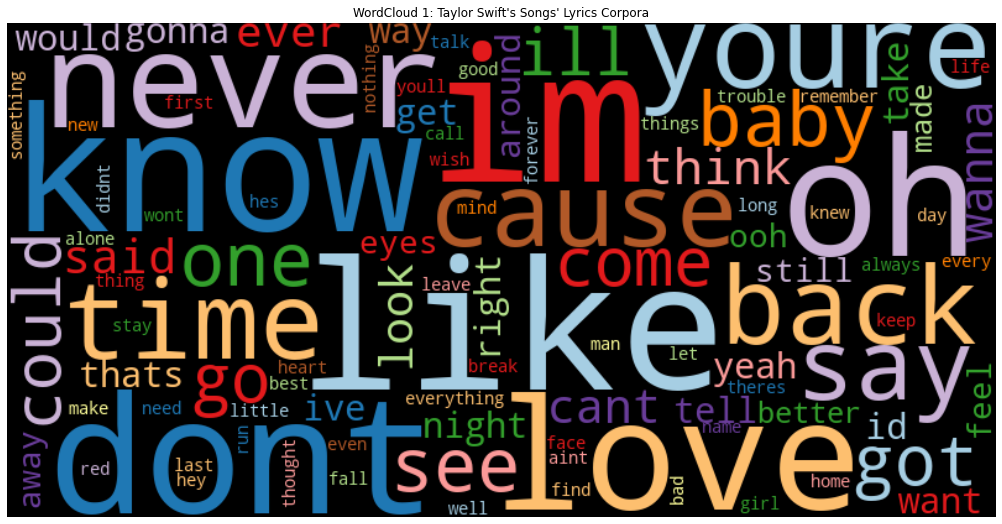

In [38]:
plt.figure(figsize=(40,20))
plt.subplot(2,2,1)
# WordCloud 1 (Taylor Swift's Lyrics)
plt.plot()
freq_lyr_taylor_df = count_words(df_taylor_lyrics)
wordcloud(freq_lyr_taylor_df['freq'], max_words=100)
plt.title("WordCloud 1: Taylor Swift's Songs' Lyrics Corpora")

plt.show()

In [33]:
freq_lyr_taylor_df.head()

,freq
token,
im,1020
like,955
know,876
oh,797
dont,786


[Text(0.5, 0, 'Frequency'),
 Text(0, 0.5, 'Word'),
 Text(0.5, 1.0, 'To TS Song Words')]

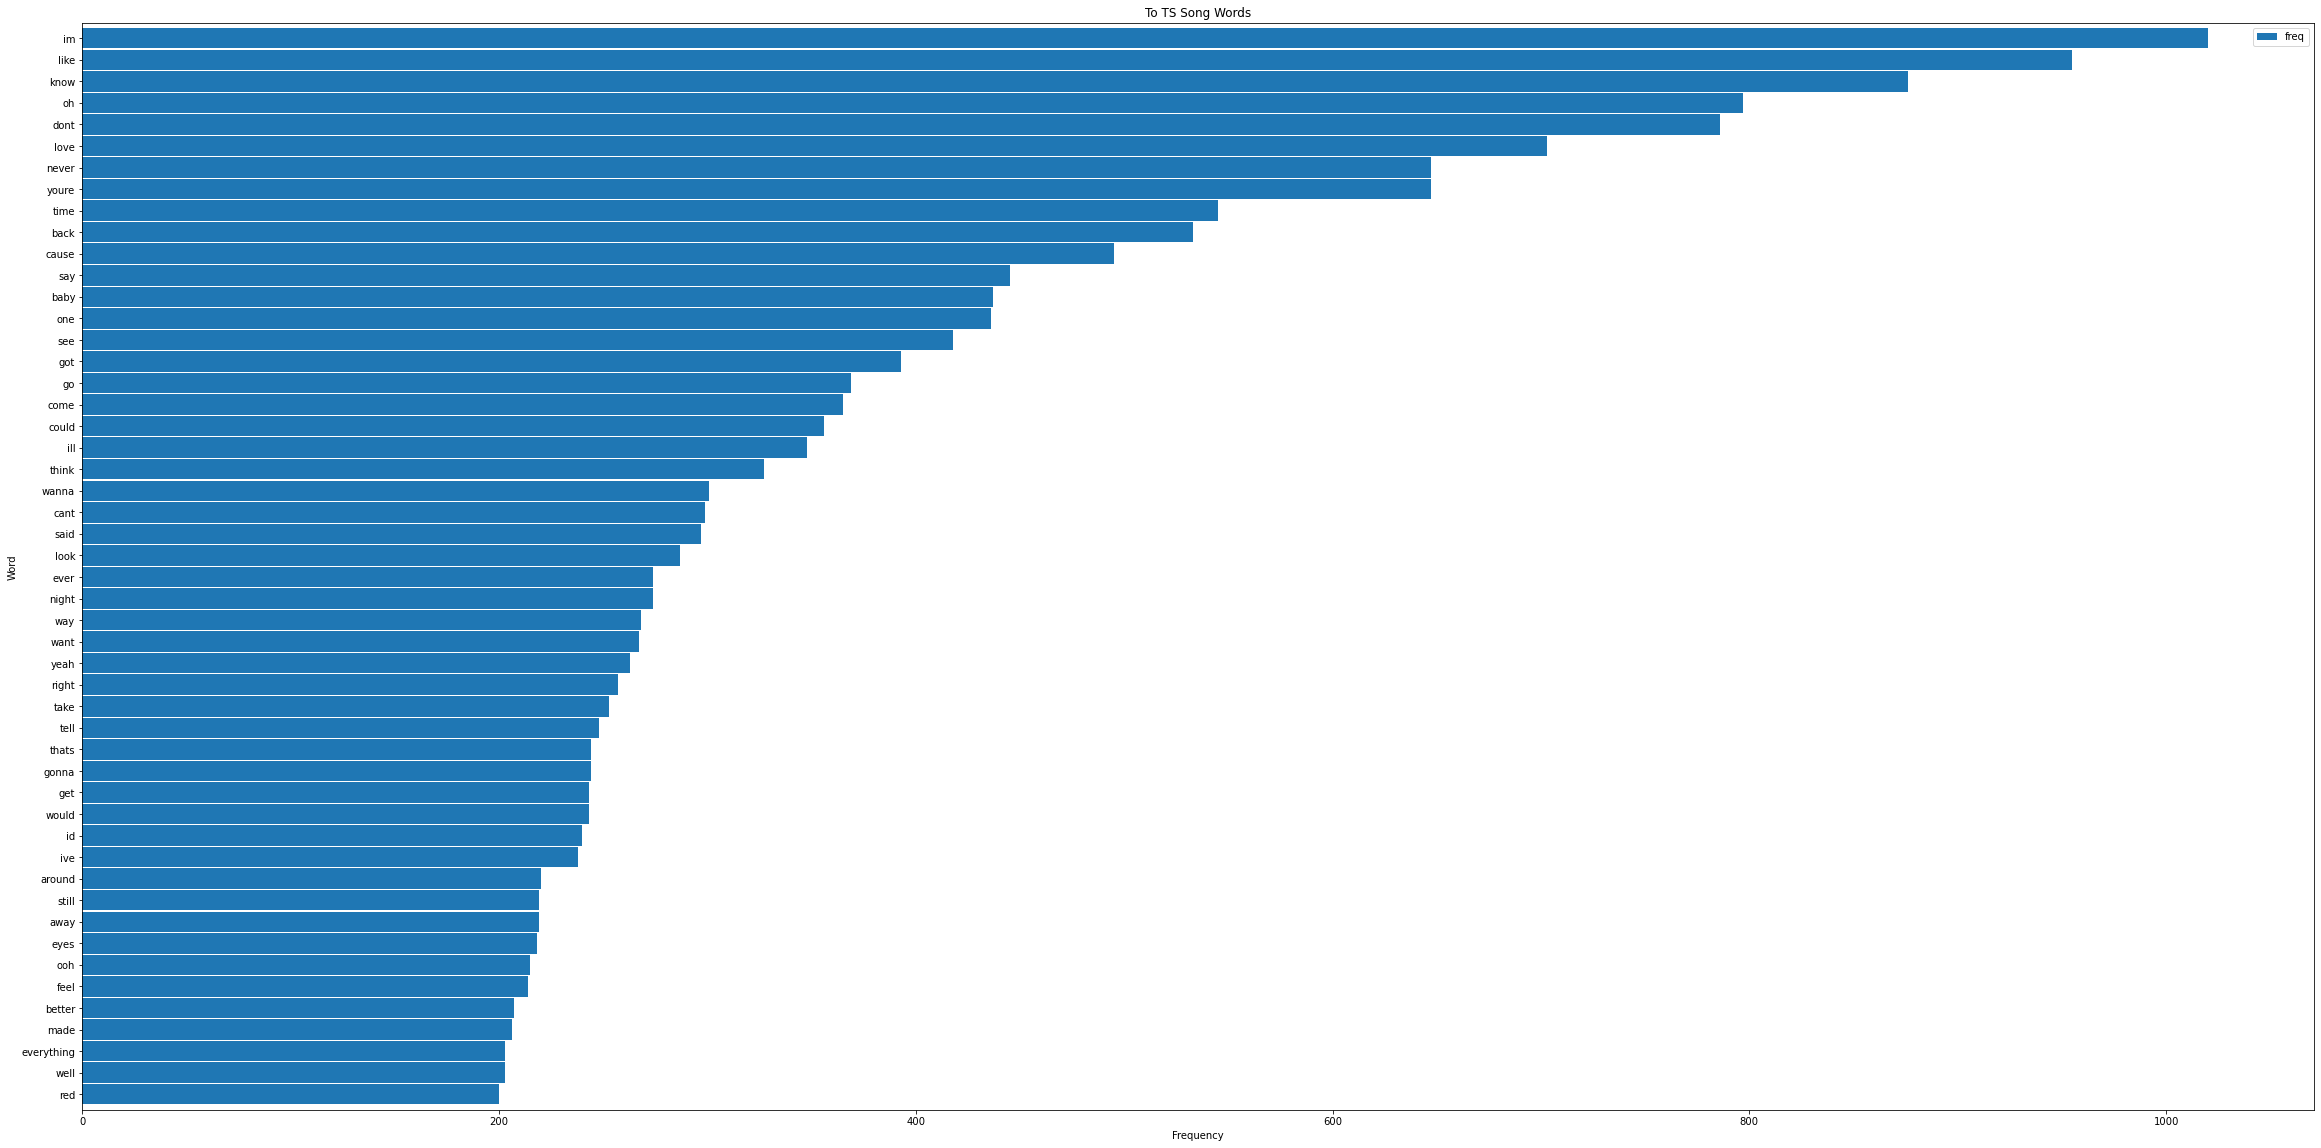

In [37]:
ax = freq_lyr_taylor_df.head(50).plot(kind='barh', width= 0.95, figsize=(40,20))
ax.invert_yaxis()
ax.set(xlabel = 'Frequency', ylabel = 'Word', title= 'To TS Song Words')

<AxesSubplot:>

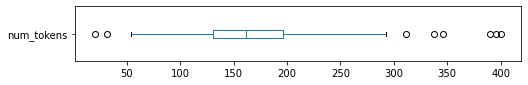

In [31]:
lyrics_data['num_tokens'].plot(kind='box', vert=False, figsize=(8, 1))

<AxesSubplot:ylabel='Frequency'>

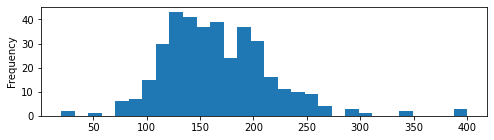

In [32]:
lyrics_data['num_tokens'].plot(kind='hist', bins= 30, figsize=(8,2))